In [1]:
import random
import pandas as pd
import numpy as np
import os, sys
import re

from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
from google.colab import drive

# 구글 드라이브와 연결
drive.mount('/content/drive')

mount_directory = "drive/MyDrive"

Mounted at /content/drive


In [3]:
# 데이터 크기 설정 ex)latest-small, 32m, ...
dataset_volume = "32m"

# CSV 데이터 로드
df_ratings = pd.read_csv(f"{mount_directory}/ml-{dataset_volume}/ratings.csv")
df_movies = pd.read_csv(f"{mount_directory}/movies_processed_data/movies_processed_32m.csv")
df_tags = pd.read_csv(f"{mount_directory}/ml-{dataset_volume}/tags.csv")

In [4]:
df_ratings.drop(['timestamp'], axis=1, inplace=True)

# NaN 값을 빈 문자열로 대체
df_movies['director'] = df_movies['director'].fillna('')
df_movies['actors'] = df_movies['actors'].fillna('')
df_movies['genres'] = df_movies['genres'].fillna('')

In [5]:
# Dataset의 User, Movie 수 확인
n_users = df_ratings.userId.unique().shape[0]
n_items = df_ratings.movieId.unique().shape[0]
print("num users: {}, num items:{}".format(n_users, n_items))

num users: 200948, num items:84432


In [6]:
movie_rate = dict()

for row in df_ratings.itertuples(index = False):
  user_id, movie_id, rate = row
  if movie_id not in movie_rate:
    movie_rate[movie_id] = [0, 0]
  movie_rate[movie_id][0] += rate
  movie_rate[movie_id][1] += 1

In [7]:
for key, value in movie_rate.items():
  value1 = value[0] / value[1]
  movie_rate[key] = [round(value1, 3),value[1]]

In [8]:
rates = dict()
rates['movieId'] = []
rates['score'] = []
rates['count'] = []
for key, value in movie_rate.items():
  rates['movieId'].append(key)
  rates['score'].append(value[0])
  rates['count'].append(value[1])

In [9]:
scores = pd.DataFrame(rates)
scores

,movieId,score,count
0,17,3.945,22251
1,25,3.676,22525
2,29,3.930,9413
3,30,3.630,1300
4,32,3.910,55275
...,...,...,...
84427,137537,2.500,1
84428,150562,0.500,1
84429,175771,4.000,1
84430,157917,5.000,1


In [10]:
df_movies = pd.merge(df_movies, scores, on='movieId')

In [11]:
df_movies.head(4)

,movieId,title,genres,year,director,actors,score,count
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995.0,JohnLasseter,TomHanks TimAllen DonRickles,3.897,68997
1,2,Jumanji,Adventure Children Fantasy,1995.0,JoeJohnston,RobinWilliams KirstenDunst BradleyPierce,3.276,28904
2,3,Grumpier Old Men,Comedy Romance,1995.0,HowardDeutch,WalterMatthau JackLemmon Ann-Margret,3.139,13134
3,4,Waiting to Exhale,Comedy Drama Romance,1995.0,ForestWhitaker,WhitneyHouston AngelaBassett LorettaDevine,2.845,2806


In [12]:
m = df_movies['count'].quantile(0.89)

In [13]:
m

201.5899999999965

In [14]:
C = df_movies['score'].mean()

In [15]:
print(C)
print(m)

3.0050824805760845
201.5899999999965


In [16]:
def weighted_rating(x, m=m, C=C):
    v = x['count']
    R = x['score']

    return ( v / (v+m) * R ) + (m / (m + v) * C)

In [17]:
df_movies['weighted_score'] = df_movies.apply(weighted_rating, axis = 1)

In [18]:
processed_data = df_movies.loc[df_movies['count'] >= m]

# 기존 index를 무시하고 새로운 index 설정
processed_data = processed_data.reset_index(drop=True)

In [19]:
processed_data

,movieId,title,genres,year,director,actors,score,count,weighted_score
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995.0,JohnLasseter,TomHanks TimAllen DonRickles,3.897,68997,3.894402
1,2,Jumanji,Adventure Children Fantasy,1995.0,JoeJohnston,RobinWilliams KirstenDunst BradleyPierce,3.276,28904,3.274124
2,3,Grumpier Old Men,Comedy Romance,1995.0,HowardDeutch,WalterMatthau JackLemmon Ann-Margret,3.139,13134,3.136976
3,4,Waiting to Exhale,Comedy Drama Romance,1995.0,ForestWhitaker,WhitneyHouston AngelaBassett LorettaDevine,2.845,2806,2.855730
4,5,Father of the Bride Part II,Comedy,1995.0,CharlesShyer,SteveMartin DianeKeaton MartinShort,3.060,13154,3.059171
...,...,...,...,...,...,...,...,...,...
9283,286905,Indiana Jones and the Dial of Destiny,Action Adventure,2023.0,JamesMangold,HarrisonFord PhoebeWaller-Bridge MadsMikkelsen,3.201,293,3.121146
9284,287633,Asteroid City,Comedy Drama Romance Sci-Fi,2023.0,WesAnderson,JasonSchwartzman ScarlettJohansson TomHanks,3.481,366,3.311969
9285,287699,Oppenheimer,Drama,2023.0,ChristopherNolan,CillianMurphy EmilyBlunt MattDamon,4.083,1152,3.922466
9286,288265,Mission: Impossible - Dead Reckoning Part One,Action Adventure Thriller,2023.0,ChristopherMcQuarrie,TomCruise HayleyAtwell VingRhames,3.769,424,3.522835


In [20]:
count_vector_triple = CountVectorizer(ngram_range=(1, 3))
count_vector_once = CountVectorizer(ngram_range=(1, 1))

In [21]:
c_vector_genres = count_vector_triple.fit_transform(processed_data['genres'])
c_vector_genres

<9288x580 sparse matrix of type '<class 'numpy.int64'>'
	with 41978 stored elements in Compressed Sparse Row format>

In [22]:
c_vector_director = count_vector_once.fit_transform(processed_data['director'])
c_vector_director

<9288x3621 sparse matrix of type '<class 'numpy.int64'>'
	with 9609 stored elements in Compressed Sparse Row format>

In [23]:
c_vector_actors = count_vector_triple.fit_transform(processed_data['actors'])
c_vector_actors

<9288x37822 sparse matrix of type '<class 'numpy.int64'>'
	with 57486 stored elements in Compressed Sparse Row format>

In [24]:
#코사인 유사도를 구한 벡터를 미리 저장
gerne_c_sim = cosine_similarity(c_vector_genres, c_vector_genres)

In [25]:
#코사인 유사도를 구한 벡터를 미리 저장
director_c_sim = cosine_similarity(c_vector_director, c_vector_director)

In [26]:
#코사인 유사도를 구한 벡터를 미리 저장
actors_c_sim = cosine_similarity(c_vector_actors, c_vector_actors)

In [27]:
# 가중치 설정
weights = [0.5, 0.1, 0.4]

# 가중치 합산
combined_similarity = (
    weights[0] * gerne_c_sim +
    weights[1] * director_c_sim +
    weights[2] * actors_c_sim
)

# 각 row에서 유사도를 정렬 (내림차순)
sorted_indices = combined_similarity.argsort()[:, ::-1]

# 결과 확인
print(sorted_indices)

[[   0 2418 6963 ... 4549 4552 4643]
 [   1 8078 3629 ... 5754 5755 4643]
 [   2 6543  219 ... 3556 3557 6767]
 ...
 [9285 1289 6839 ... 5238 5240    0]
 [9286 8748 7835 ... 5137 5138 4643]
 [9287 8610 1807 ... 7195 4045 4643]]


In [28]:
def get_recommend_movie_list(df, movie_title, top=20):
    # 특정 영화와 비슷한 영화를 추천해야 하기 때문에 '특정 영화' 정보를 뽑아낸다.
    target_movie_index = df[df['title'] == movie_title].index.values

    #코사인 유사도 중 비슷한 코사인 유사도를 가진 정보를 뽑아낸다.
    sim_index = sorted_indices[target_movie_index, :top].reshape(-1)
    #본인을 제외
    sim_index = sim_index[sim_index != target_movie_index]

    #data frame으로 만들고 vote_count으로 정렬한 뒤 return
    result = df.iloc[sim_index].sort_values('weighted_score', ascending=False)[:20]
    return result

In [29]:
rec_movies = get_recommend_movie_list(processed_data, movie_title='Deadpool')

In [30]:
rec = list(rec_movies['title'])[:20]
rec

['Back to the Future',
 'Fifth Element, The',
 'Deadpool 2',
 'Galaxy Quest',
 'Back to the Future Part II',
 'Star Trek IV: The Voyage Home',
 "Hitchhiker's Guide to the Galaxy, The",
 'Free Guy',
 'Sexmission',
 "Bill & Ted's Excellent Adventure",
 'Last Starfighter, The',
 'Who Am I?',
 'Adventures of Buckaroo Banzai Across the 8th Dimension, The',
 'Paul',
 'Innerspace',
 'The Adam Project',
 'Our Man Flint',
 'Space Cowboys',
 'Bill & Ted Face the Music',
 'Barbarella']

In [34]:
import requests
from urllib.request import urlopen
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

def movie_poster(titles):
    data_URL = 'http://www.omdbapi.com/?i=tt3896198&apikey=f9cdaffd'

    fig, axes = plt.subplots(2, 10, figsize=(30,9))

    for i, ax in enumerate(axes.flatten()):
        w_title = titles[i].strip().split()
        params = {
            's':titles[i],
            'type':'movie',
            'y':''
        }
        response = requests.get(data_URL,params=params).json()

        if response["Response"] == 'True':
            poster_URL = response["Search"][0]["Poster"]
            img = Image.open(urlopen(poster_URL))
            ax.imshow(img)

        ax.axis("off")
        if len(w_title) >= 10:
            ax.set_title(f"{i+1}. {' '.join(w_title[:5])}\n{' '.join(w_title[5:10])}\n{' '.join(w_title[10:])}", fontsize=10)
        elif len(w_title) >= 5:
            ax.set_title(f"{i+1}. {' '.join(w_title[:5])}\n{' '.join(w_title[5:])}", fontsize=10)
        else:
            ax.set_title(f"{i+1}. {titles[i]}", fontsize=10)

    plt.show()

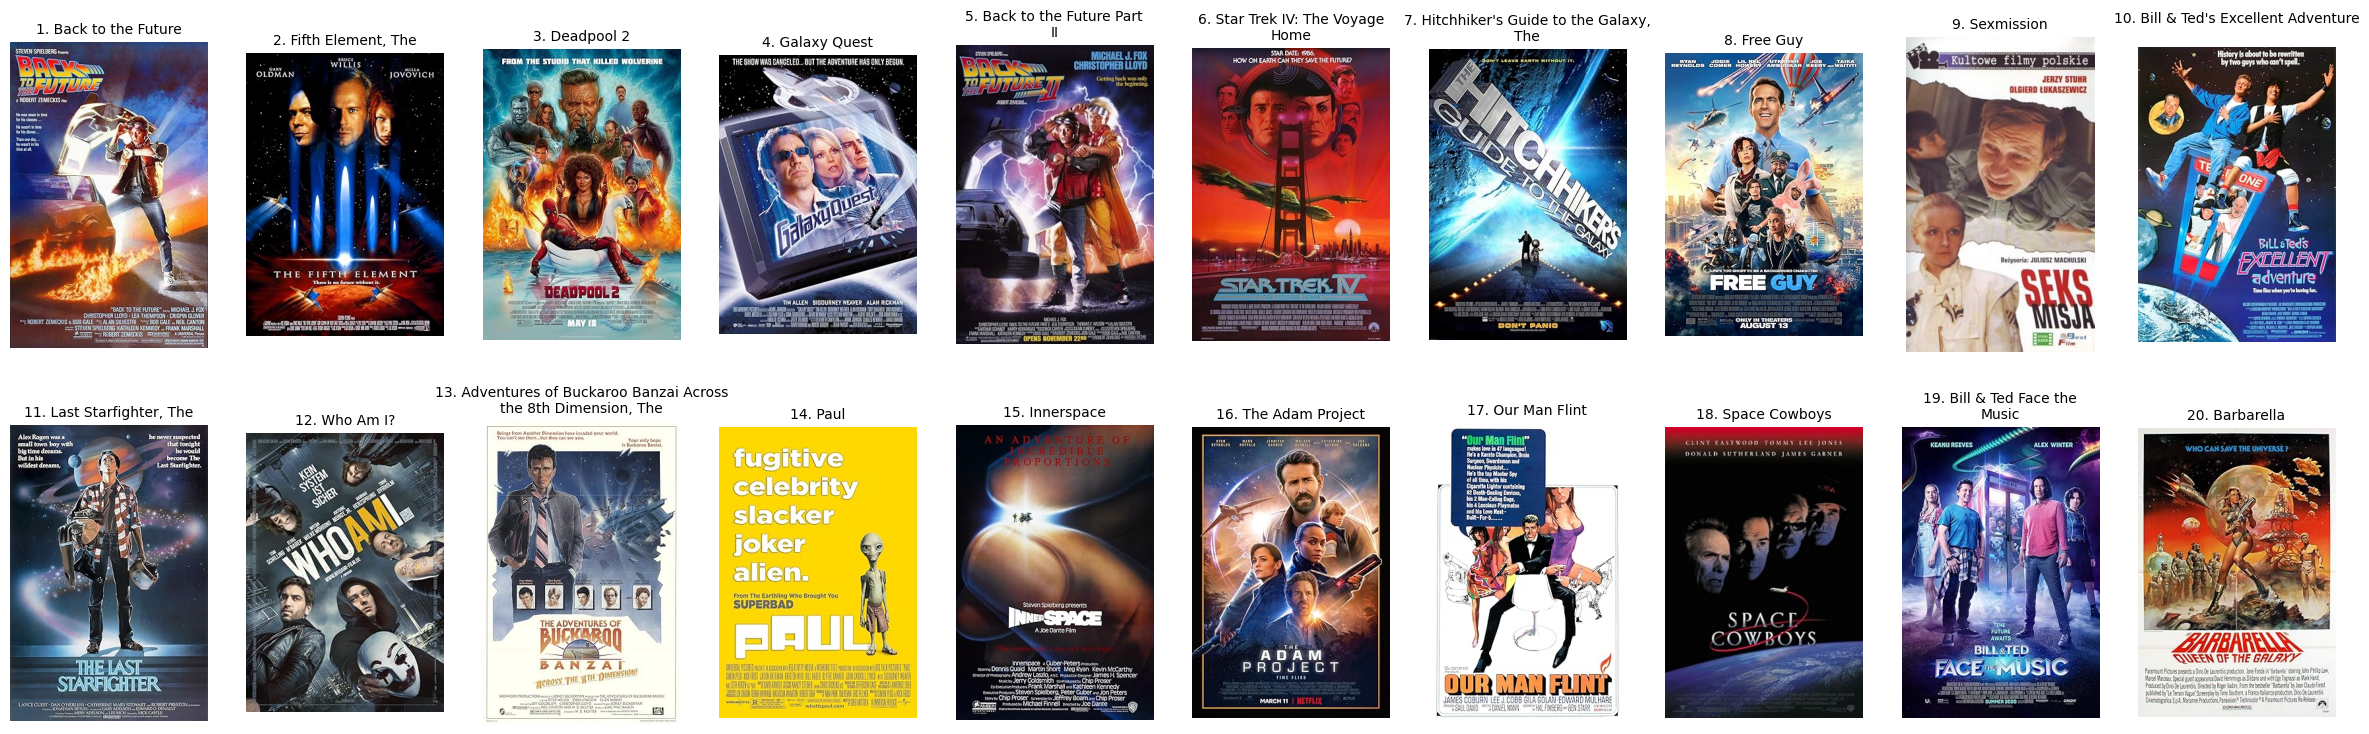

In [35]:
movie_poster(rec)